## Final Model - Ranking & Smart Estimate

# **Analyst Consensus Model** - Capstone Project: DWS - ESADE Business School

#### **Tutor:** Jarrid Klug
#### **Members:** Alex Casas, Daniel Pace, Enric Aletà

### **Introduction**

The goal of this project is to develop a robust model to evaluate the accuracy of analyst predictions. By analyzing historical predictions and their realized values, we aim to rank analysts based on their performance and construct a weighted consensus ("smart") estimate that outperforms simple averaging methods. This approach can provide valuable insights for decision-making and improve the reliability of aggregated forecasts.

In [1]:
import pandas as pd

df = pd.read_csv("final_dataset.csv")  # estimates dataset
df.head()

,Ticker,Period,Horizon,Estimate_Type,Contributor,Analyst,Predicted_Value,Actual_Value,Currency,Country,...,USD/CNY,Tech ETF,Financials ETF,Healthcare ETF,Energy ETF,Consumer Discretionary ETF,Utilities ETF,Consumer Staples ETF,Industrials ETF,Materials ETF
0,ORCL.K,Q1 Aug-04,Quarter,Revenue,CITIZENS,"Walravens, Patrick D",2219.50,2215.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
1,ORCL.K,Q1 Aug-04,Quarter,EPS,WILLIAM BLAIR & COMPANY,"Naji, Sebastien",0.10,0.1,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
2,ORCL.K,Q1 Aug-04,Quarter,EPS,CITIZENS,"Walravens, Patrick D",0.09,0.1,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
3,ORCL.K,Q1 Aug-04,Quarter,Net Income,CITIZENS,"Walravens, Patrick D",458.70,509.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
4,ORCL.K,Q1 Aug-04,Quarter,Net Income,PIPER SANDLER COMPANIES,"Bracelin, Brent A",491.90,509.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615


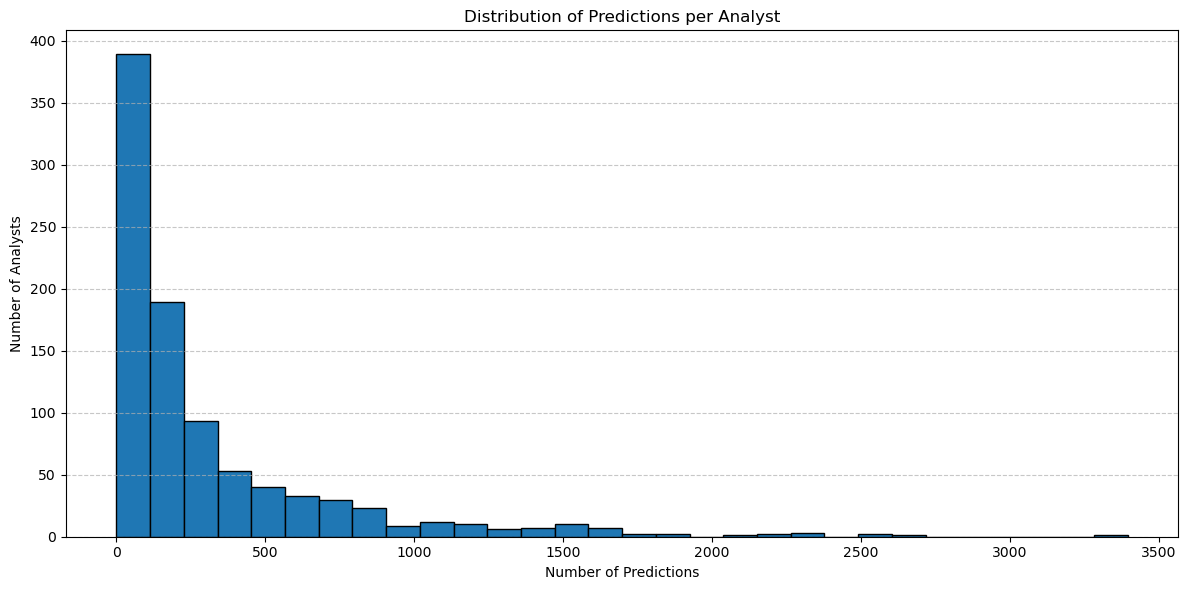

In [2]:
import matplotlib.pyplot as plt 

analyst_counts = df["Analyst"].value_counts()
plt.figure(figsize=(12, 6))
plt.hist(analyst_counts, bins=30, edgecolor="black")
plt.title("Distribution of Predictions per Analyst")
plt.xlabel("Number of Predictions")
plt.ylabel("Number of Analysts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
analyst_counts

Analyst
Read, Roger D         3395
MacGregor, David S    2658
Martin, Laura A       2596
Griffin, Bobby        2492
Bittner, Brian        2356
                      ... 
Kim, Choong-Hyun         3
Lee, Minjae              2
Seo, Mihwa               2
Ding, Ethan              1
Kim, Jingu               1
Name: count, Length: 925, dtype: int64

In [4]:
median = analyst_counts.median()
percentile_10 = analyst_counts.quantile(0.10)
percentile_25 = analyst_counts.quantile(0.25)
percentile_75 = analyst_counts.quantile(0.75)
percentile_90 = analyst_counts.quantile(0.90)

print(f"Median: {median}")
print(f"10th percentile: {percentile_10}")
print(f"25th percentile: {percentile_25}")
print(f"75th percentile: {percentile_75}")
print(f"90th percentile: {percentile_90}")

Median: 150.0
10th percentile: 15.0
25th percentile: 53.0
75th percentile: 378.0
90th percentile: 821.6


To ensure **robust** and **fair evaluation** of analyst performance, we apply a filtering criterion based on the number of forecasts each analyst has made. In the raw dataset, there is a highly uneven distribution: while some analysts have issued over 3,000 predictions, a substantial portion have contributed only a handful. Analysts with very few forecasts introduce noise and variance into the analysis, as their performance metrics are not statistically meaningful. For example, an analyst with only one or two accurate predictions may appear to outperform others, not due to skill but due to insufficient data. Including such cases can distort both ranking systems and model training processes.

To address this, we remove all analysts with fewer than **50 forecasts**. This threshold balances two goals: reducing statistical noise from low-activity analysts while retaining a sufficiently broad and representative sample for modeling. Analysts above this threshold provide enough data to compute stable accuracy estimates and contribute meaningfully to downstream tasks such as ML-based consensus models.

In [5]:
threshold = 50
valid_analysts = analyst_counts[analyst_counts >= threshold].index

df_filtered = df[df["Analyst"].isin(valid_analysts)].copy()

print(f"Original rows: {len(df)}")
print(f"Original number of analysts: {df["Analyst"].nunique()}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"Remaining analysts: {df_filtered["Analyst"].nunique()}")

Original rows: 288292
Original number of analysts: 925
Filtered rows: 283665
Remaining analysts: 703


In [6]:
df = df_filtered
df.isna().sum().sum() # check if there are any NA's

0

In this project, we define the target variable as the **absolute percent error** of each analyst forecast. This formulation measures the magnitude of the forecasting error, independent of whether the analyst overestimated or underestimated the true value.

Although this approach ignores the **direction of the error** (i.e., it **does not distinguish** between **optimistic** vs. **pessimistic forecasts**), it is fully aligned with our modeling goal. Our objective is not to analyze **systematic bias**, but rather to rank analysts by the accuracy of their predictions and construct a **smart consensus estimate** by giving more weight to those who consistently forecast well. For this purpose, what matters is how close their estimates are to the truth, not whether they tend to err upwards or downwards.

In [7]:
# We create target variable - absolute percent error
df["PctErr"] = abs(df["Predicted_Value"] - df["Actual_Value"]) / (abs(df["Actual_Value"]) + 1e-6)

In [8]:
df.columns

Index(['Ticker', 'Period', 'Horizon', 'Estimate_Type', 'Contributor',
       'Analyst', 'Predicted_Value', 'Actual_Value', 'Currency', 'Country',
       'Industry', 'Sector', 'Company_Name', 'Target_Period_End', 'S&P 500',
       'Nasdaq 100', 'Dow Jones', 'Russell 2000', 'Emerging Markets', 'VIX',
       'Nasdaq Volatility (VXN)', 'US 2Y Yield', 'US 10Y Yield',
       'US 30Y Yield', '7-10Y Treasury Bond ETF', '20Y Treasury Bond ETF',
       'Fed Funds Futures', 'US Corporate Bonds', 'WTI Crude Oil', 'Gold',
       'Silver', 'Copper', 'Natural Gas', 'TIPS ETF', 'US Dollar Index',
       'USD/EUR', 'USD/JPY', 'USD/GBP', 'USD/CNY', 'Tech ETF',
       'Financials ETF', 'Healthcare ETF', 'Energy ETF',
       'Consumer Discretionary ETF', 'Utilities ETF', 'Consumer Staples ETF',
       'Industrials ETF', 'Materials ETF', 'PctErr'],
      dtype='object')

In [9]:
# df = df.drop(columns=["Company_Name"]) # drop Company_Name, redundant with ticker

In [9]:
df.head()

,Ticker,Period,Horizon,Estimate_Type,Contributor,Analyst,Predicted_Value,Actual_Value,Currency,Country,...,Tech ETF,Financials ETF,Healthcare ETF,Energy ETF,Consumer Discretionary ETF,Utilities ETF,Consumer Staples ETF,Industrials ETF,Materials ETF,PctErr
0,ORCL.K,Q1 Aug-04,Quarter,Revenue,CITIZENS,"Walravens, Patrick D",2219.50,2215.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.002032
1,ORCL.K,Q1 Aug-04,Quarter,EPS,WILLIAM BLAIR & COMPANY,"Naji, Sebastien",0.10,0.1,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.000000
2,ORCL.K,Q1 Aug-04,Quarter,EPS,CITIZENS,"Walravens, Patrick D",0.09,0.1,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.099999
3,ORCL.K,Q1 Aug-04,Quarter,Net Income,CITIZENS,"Walravens, Patrick D",458.70,509.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.098821
4,ORCL.K,Q1 Aug-04,Quarter,Net Income,PIPER SANDLER COMPANIES,"Bracelin, Brent A",491.90,509.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.033595


## Approach 1: 

## Approach 1: Heuristic Analyst Scoring Based on Forecast Accuracy

Before introducing machine learning models, we begin with a transparent, interpretable approach that ranks analysts based solely on their historical forecasting accuracy. Although this method is not predictive in nature, it serves as a strong baseline and provides useful insight into analyst performance without requiring model training. Its simplicity and explainability make it especially attractive for exploratory stages and stakeholder-facing diagnostics.

We first define the **absolute percent error** for each forecast. Let $p_i$ denote the predicted value and $y_i$ the actual realized value. The forecast error $e_i$ is computed as:

$$
e_i = \frac{|p_i - y_i|}{|y_i| + \varepsilon}
\quad,\quad \varepsilon = 10^{-6}
$$

This becomes our target variable `PctErr`, capturing the relative deviation of each forecast from the truth.

For each analyst $a$, we calculate their **average percent error** across all their forecasts:

$$
\text{AvgPctErr}_a = \frac{1}{|I_a|} \sum_{i \in I_a} e_i
$$

where $I_a$ is the set of forecasts made by analyst $a$. To convert this into a performance score, we apply an exponential decay function with a tunable penalty parameter $\alpha$:

$$
\text{RawScore}_a = 100 \cdot \exp(-\alpha \cdot \text{AvgPctErr}_a)
$$

This function rewards analysts with lower errors and penalizes those with higher deviations. To standardize the scores across all analysts, we normalize them to a 0–100 scale:

$$
\text{Score}_a = 100 \cdot \frac{\text{RawScore}_a - \min_b \text{RawScore}_b}{\max_b \text{RawScore}_b - \min_b \text{RawScore}_b + \varepsilon}
$$

This produces an intuitive ranking where higher scores indicate better historical accuracy. The framework also allows for filtering by sector, ticker, or financial metric, enabling targeted benchmarking across different dimensions of interest.

In [38]:
import numpy as np

def get_analyst_ranking(df, sector=None, ticker=None, metric=None, alpha=5):
    """
    Computes analyst rankings based on average percent error,
    optionally filtered by sector, ticker (company), and metric (Estimate_Type).

    Parameters:
        df: DataFrame with 'PctErr', 'Analyst', and optionally 'Sector', 'Ticker', 'Estimate_Type'
        sector (str): Optional sector name to filter
        ticker (str): Optional ticker or company name to filter
        metric (str): Optional Estimate_Type to filter (e.g., 'EPS', 'Revenue', etc.)
        alpha (float): Penalty factor for error scaling in score (higher = more punishment)

    Returns:
        DataFrame with Analyst, AvgPctErr, and Score (0–100 scaled)
    """
    subset = df.copy()
    
    if sector:
        subset = subset[subset["Sector"] == sector]
    if ticker:
        subset = subset[subset["Ticker"] == ticker]
    if metric:
        subset = subset[subset["Estimate_Type"] == metric]
    
    if subset.empty:
        return pd.DataFrame(columns=["Analyst", "AvgPctErr", "Score"])

    # AVG error per analyst
    scores = subset.groupby("Analyst")["PctErr"].mean().reset_index()
    scores.rename(columns={"PctErr": "AvgPctErr"}, inplace=True)

    # Exponential penalty
    scores["Score"] = 100 * np.exp(-alpha * scores["AvgPctErr"])

    # Normalize scores to 0–100 scale
    scores["Score"] = 100 * (scores["Score"] - scores["Score"].min()) / (scores["Score"].max() - scores["Score"].min() + 1e-6)

    # Final sort
    scores = scores.sort_values("Score", ascending=False).reset_index(drop=True)
    return scores[["Analyst", "AvgPctErr", "Score"]]

In [11]:
get_analyst_ranking(df)

,Analyst,AvgPctErr,Score
0,"Hudson, Sam",0.015262,99.999999
1,"Rea, Cooper",0.017797,98.740378
2,"Toung, David H",0.019641,97.834401
3,"Young, Matthew J",0.020433,97.447971
4,"Lewis, Edward J",0.021506,96.926156
...,...,...,...
698,"Cikos, Michael",239.333706,0.000000
699,"Schackart, Ralph E",194.444687,0.000000
700,"Biros, Brian",757.772300,0.000000
701,"White, Brian J",355.089926,0.000000


In [12]:
get_analyst_ranking(df, sector="Technology")

,Analyst,AvgPctErr,Score
0,"Zhao, Dan",0.004590,99.999999
1,"Moffett, Craig E",0.012885,95.937476
2,"Xia, Jun",0.013510,95.637991
3,"Rea, Cooper",0.017797,93.609730
4,"Kapulskis, Thiago",0.020056,92.558760
...,...,...,...
168,"Schwab, Christian D",1185.637067,0.000000
169,"Berg, Scott R",278.624205,0.000000
170,"Seyrafi, Shebly",303.848637,0.000000
171,"Singh, Param",249.050905,0.000000


In [13]:
get_analyst_ranking(df, ticker="AAPL.O")

,Analyst,AvgPctErr,Score
0,"Talsania, Parth",0.003309,99.999997
1,"Fu, Tianzi",0.006564,94.993649
2,"Kapulskis, Thiago",0.009077,91.183189
3,"Bollin, Ben J",0.009351,90.770503
4,"Moffett, Craig E",0.012885,85.499726
5,"Xia, Jun",0.013510,84.576778
6,"Nispel, Brandon",0.025549,67.358947
7,"Kelleher, Jim N",0.027894,64.124606
8,"Kerwin, William",0.028592,63.168399
9,"Forte, Thomas F",0.037545,51.203095


To enable proper temporal aggregation and model evaluation, we convert the original `Period` strings into structured datetime values using a custom parsing function.

The raw period data contains entries such as `"Q1 Aug-04"` for quarterly forecasts or `"FY Aug-04"` for full-year forecasts. These strings encode both the **fiscal horizon** (e.g., Q1, FY) and the **base date** (e.g., August 2004), and need to be transformed into interpretable timestamps.

We define the parsing logic as follows:

For **full-year horizons** (e.g., `"FY Aug-04"`), we remove the `"FY "` prefix and parse the result directly as a datetime in the format `"%b-%y"`.

For **quarterly horizons** (e.g., `"Q1 Aug-04"`), we:
1. Extract the quarter identifier $q \in \{\text{Q1}, \text{Q2}, \text{Q3}, \text{Q4} \}$ and the base month-year string.
2. Convert the month-year component to a datetime object $t \in \mathbb{R}$ using the format `"%b-%y"`.
3. Apply an offset depending on the quarter using the mapping:

$$
\text{Q1} \mapsto 0,\quad \text{Q2} \mapsto 3,\quad \text{Q3} \mapsto 6,\quad \text{Q4} \mapsto 9
$$

This produces the final timestamp:

$$
\text{ParsedPeriod}_i = t + \text{offset}_q \text{ months}
$$

In [14]:
def parse_period(period_str, horizon):
    """Convert period string to datetime."""
    try:
        if horizon == "FY":
            return pd.to_datetime(period_str.replace("FY ", ""), format="%b-%y")
        elif horizon == "Quarter":
            q, month_year = period_str.split()
            base_date = pd.to_datetime(month_year, format="%b-%y")
            quarter_offset = {"Q1": 0, "Q2": 3, "Q3": 6, "Q4": 9}.get(q, 0)
            return base_date + pd.DateOffset(months=quarter_offset)
    except:
        return pd.NaT

To optimize the construction of **smart consensus forecasts**, we calibrate a sector-specific penalty factor $\alpha$ that controls the degree to which analyst errors are penalized in the weighting scheme.

Recall that the smart consensus is a **weighted average** of analyst predictions:

$$
\widehat{y}_t^{\text{smart}} = \frac{ \sum_{a \in A_t} w_{a,t} \cdot \hat{y}_{a,t} }{ \sum_{a \in A_t} w_{a,t} }
\quad \text{with} \quad
w_{a,t} = 100 \cdot \exp(-\alpha \cdot \overline{e}_a)
$$

where:
- $\hat{y}_{a,t}$ is analyst $a$’s forecast at time $t$,
- $\overline{e}_a$ is the average historical **percent error** for analyst $a$,
- $\alpha$ is a **hyperparameter** that controls how much poor past performance is penalized.

We aim to find the **optimal $\alpha$ for each sector** by minimizing out-of-sample prediction error using a **75/25 time-based train/test split** on each ticker-metric pair.

### Procedure:

1. **Define a grid** of candidate values for $\alpha$:
   $$
   \alpha \in \{10^{-3}, 10^{-2.9}, \dots, 10^{2.5} \}
   $$
   spanning weak to strong penalization.

2. For each **sector**, and each $(\text{Ticker}, \text{Estimate Type})$ pair within that sector:
   - Filter out estimates with fewer than 10 observations or fewer than 4 unique forecast periods.
   - Parse the forecast `Period` and `Horizon` into datetime format using a custom function.

3. **Split the time series** into 75% train and 25% test based on unique forecast dates:
   - Train is used to compute analyst error scores $\overline{e}_a$.
   - Test is used to compute **smart consensus** forecasts using those scores.

4. For each $\alpha$:
   - Compute weights $w_a = 100 \cdot \exp(-\alpha \cdot \overline{e}_a)$ on the training set.
   - Use these to aggregate smart forecasts in the test set.
   - Compute absolute percentage error:
     $$
     \text{SmartErr}_t = \frac{|\widehat{y}_t^{\text{smart}} - y_t|}{|y_t| + 10^{-6}}
     $$
   - Store the **mean** test error for each $\alpha$.

5. After iterating over all tickers in the sector, compute the **median** of the mean errors for each $\alpha$ across all ticker-metric combinations.

6. The **optimal $\alpha^\star$ for the sector** is defined as:
   $$
   \alpha^\star = \arg\min_{\alpha} \; \text{MedianSmartError}_\alpha
   $$

This tuning process ensures that each sector receives a tailored penalization factor that balances sensitivity to analyst error with the ability to generalize across different firms.

In [15]:
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

alpha_grid = np.round(np.logspace(-3, 2.5, 100), 3) # define alpha grid to test
sector_alpha_results = [] # optimal alpha per sector
sectors = df["Sector"].dropna().unique() # get all sectors in the dataset

# Helper function for safe weighted average
def safe_weighted_avg(g, alpha):
    if "Score" not in g.columns or g["Score"].sum() == 0:
        return np.nan
    return np.average(g["Predicted_Value"], weights=g["Score"])

# Grid search alpha per sector using median-based evaluation
for sector in tqdm(sectors, desc="Tuning alpha per sector (median error)"):
    sector_df = df[df["Sector"] == sector].copy()
    grouped = sector_df.groupby(["Ticker", "Estimate_Type"])

    alpha_errors = defaultdict(list)

    for (ticker, metric), group in grouped:
        group = group.dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon"])
        if len(group) < 10:
            continue

        group["Parsed_Period"] = group.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
        group = group.dropna(subset=["Parsed_Period"])

        if group["Parsed_Period"].nunique() < 4:
            continue

        # Sort by date and split 75/25 train/test
        unique_dates = sorted(group["Parsed_Period"].unique())
        cutoff = int(len(unique_dates) * 0.75)
        train_periods = unique_dates[:cutoff]
        test_periods = unique_dates[cutoff:]

        train = group[group["Parsed_Period"].isin(train_periods)].copy()
        test = group[group["Parsed_Period"].isin(test_periods)].copy()

        # Train analyst scores on train
        analyst_scores = train.groupby("Analyst")["PctErr"].mean().reset_index()

        for alpha in alpha_grid:
            analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])
            test_scored = test.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left")
            test_scored = test_scored.dropna(subset=["Score"])

            if test_scored.empty:
                continue

            # Compute smart consensus for test periods
            smart_consensus = test_scored.groupby("Parsed_Period", group_keys=False, observed=True).apply(
                lambda g: safe_weighted_avg(g.drop(columns=["Parsed_Period"], errors="ignore"), alpha)
            )
            actual_values = test_scored.groupby("Parsed_Period")["Actual_Value"].first()

            temp = pd.DataFrame({
                "Smart": smart_consensus,
                "Actual": actual_values
            }).dropna()

            if temp.empty:
                continue

            temp["SmartErr"] = abs(temp["Smart"] - temp["Actual"]) / (abs(temp["Actual"]) + 1e-6)
            alpha_errors[alpha].append(temp["SmartErr"].mean())

    # Aggregate sector-level **median** smart error for each alpha
    if alpha_errors:
        med_errors = {alpha: np.median(errs) for alpha, errs in alpha_errors.items()}
        best_alpha = min(med_errors, key=med_errors.get)
        best_error = med_errors[best_alpha]
        sector_alpha_results.append({
            "Sector": sector,
            "Optimal_Alpha": best_alpha,
            "Smart_Error_CV_Median": best_error
        })

# Create final DataFrame
alpha_tuning_df_median = pd.DataFrame(sector_alpha_results)
alpha_tuning_df_median

Tuning alpha per sector (median error): 100%|██████████| 10/10 [18:39<00:00, 111.92s/it]


,Sector,Optimal_Alpha,Smart_Error_CV_Median
0,Technology,278.256,0.080848
1,Industrials,215.443,0.053231
2,Consumer Defensive,21.544,0.052166
3,Consumer Cyclical,18.957,0.087271
4,Communication Services,8.799,0.081881
5,Healthcare,113.646,0.076366
6,Energy,31.623,0.100044
7,Utilities,10.000,0.102472
8,Financial Services,5.275,0.074062
9,Basic Materials,0.001,0.093329


After tuning the optimal penalty factor $\alpha$ for each sector using out-of-sample cross-validation, we now evaluate the performance of the **smart consensus model** on the **entire dataset**, using all historical observations, without any train/test split. This final step allows us to assess how the model behaves when making use of all available analyst estimates to compute the consensus.

For each unique combination of **Ticker** and **Estimate Type**, we start by filtering the data to ensure there are no missing values in the required columns and that the group contains forecasts for at least four different periods. Then, for each group, we retrieve the optimal sector-specific penalty $\alpha^\star$ from the lookup table constructed during the tuning phase:

Using this full set of observations, we compute analyst scores based on their overall historical accuracy. Specifically, for each analyst $a$, we calculate their average percent error $\bar{e}_a$ across all their forecasts, and then use it to compute the weight:

$$
\text{Score}_a = 100 \cdot \exp(-\alpha^\star \cdot \bar{e}_a)
$$

These scores are merged back into the original dataset. For each forecast period $t$, we compute both the **naive consensus** (a simple average of all analyst predictions for that period):

$$
\hat{y}_t^{\text{naive}} = \frac{1}{|A_t|} \sum_{a \in A_t} \hat{y}_{a,t}
$$

and the **smart consensus** (a weighted average using the score-based weights):

$$
\hat{y}_t^{\text{smart}} = \frac{\sum_{a \in A_t} w_{a,t} \cdot \hat{y}_{a,t}}{\sum_{a \in A_t} w_{a,t}} \quad \text{where} \quad w_{a,t} = \text{Score}_a
$$

We then compare both consensus values against the actual realized value $y_t$ by computing the absolute percentage error for each forecast period:

$$
\text{NaiveErr}_t = \frac{|\hat{y}_t^{\text{naive}} - y_t|}{|y_t| + 10^{-6}}, \quad
\text{SmartErr}_t = \frac{|\hat{y}_t^{\text{smart}} - y_t|}{|y_t| + 10^{-6}}
$$

Finally, we average these errors across all periods to compute the mean absolute percentage errors for each method:

$$
\text{NaiveAvgError} = \text{mean}(\text{NaiveErr}_t), \quad
\text{SmartAvgError} = \text{mean}(\text{SmartErr}_t)
$$

These results are stored in a final table `comparison_df_final`, which includes the following columns:

- **Ticker**: company identifier
- **Metric**: estimate type (e.g., EPS, Revenue)
- **Sector**: corresponding sector
- **NaiveAvgError**: average MAPE of the naive consensus
- **SmartAvgError**: average MAPE of the smart consensus
- **Alpha_Used**: optimal $\alpha^\star$ applied for weighting

In [42]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")

sector_alpha_lookup = dict(zip(alpha_tuning_df_median["Sector"], alpha_tuning_df_median["Optimal_Alpha"]))

results = []  # Store full-dataset evaluation results

# Helper for weighted average
def safe_weighted_avg(g):
    if g["Score"].sum() == 0:
        return np.nan
    return np.average(g["Predicted_Value"], weights=g["Score"])

# Group by Ticker + Estimate_Type
grouped = df.groupby(["Ticker", "Estimate_Type"])

for (ticker, metric), group in tqdm(grouped, desc="Full-dataset consensus errors per ticker-metric"):

    group = group.dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon", "Sector"])
    if group.empty:
        continue

    group["Parsed_Period"] = group.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
    group = group.dropna(subset=["Parsed_Period"])
    if group["Parsed_Period"].nunique() < 4:
        continue

    # Use full group to train scores and evaluate
    sector = group["Sector"].mode().iloc[0]
    alpha = sector_alpha_lookup.get(sector, 5.0)

    # Compute analyst scores from full group
    analyst_scores = group.groupby("Analyst")["PctErr"].mean().reset_index()
    analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])

    # Merge scores and drop missing
    group = group.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left")
    group = group.dropna(subset=["Score"])

    # Consensus values
    naive_consensus = group.groupby("Parsed_Period")["Predicted_Value"].mean()
    smart_consensus = group.groupby("Parsed_Period", group_keys=False).apply(safe_weighted_avg)
    actual_values = group.groupby("Parsed_Period")["Actual_Value"].first()

    valid_idx = naive_consensus.index.intersection(smart_consensus.index).intersection(actual_values.index)
    temp = pd.DataFrame({
        "Naive": naive_consensus.loc[valid_idx],
        "Smart": smart_consensus.loc[valid_idx],
        "Actual": actual_values.loc[valid_idx]
    })

    if temp.empty:
        continue

    temp["NaiveErr"] = abs(temp["Naive"] - temp["Actual"]) / (abs(temp["Actual"]) + 1e-6)
    temp["SmartErr"] = abs(temp["Smart"] - temp["Actual"]) / (abs(temp["Actual"]) + 1e-6)

    naive_avg = temp["NaiveErr"].mean()
    smart_avg = temp["SmartErr"].mean()

    results.append({
        "Ticker": ticker,
        "Metric": metric,
        "Sector": sector,
        "NaiveAvgError": naive_avg,
        "SmartAvgError": smart_avg,
        "Alpha_Used": alpha
    })

comparison_df_final = pd.DataFrame(results)
comparison_df_final

Full-dataset consensus errors per ticker-metric: 100%|██████████| 1108/1108 [01:54<00:00,  9.68it/s]


,Ticker,Metric,Sector,NaiveAvgError,SmartAvgError,Alpha_Used
0,003550.KS,EBIT,Industrials,0.868340,0.914626,215.443
1,003550.KS,EBITDA,Industrials,3.105302,2.780626,215.443
2,003550.KS,EPS,Industrials,1.075668,0.530357,215.443
3,003550.KS,Net Income,Industrials,0.793263,0.702285,215.443
4,003550.KS,Revenue,Industrials,0.346965,0.308155,215.443
...,...,...,...,...,...,...
1097,ZS.O,EBIT,Technology,0.416575,0.325964,278.256
1098,ZS.O,EBITDA,Technology,0.951109,0.664876,278.256
1099,ZS.O,EPS,Technology,0.416255,0.291640,278.256
1100,ZS.O,Net Income,Technology,0.395534,0.284758,278.256


In [47]:
# Compute summary metrics
total_evals = len(comparison_df_final)
median_naive = comparison_df_final["NaiveAvgError"].median()
median_smart = comparison_df_final["SmartAvgError"].median()
improvement_rate = (comparison_df_final["SmartAvgError"] < comparison_df_final["NaiveAvgError"]).mean() * 100

print(f"Total combinations evaluated: {total_evals}")
print(f"Median Naive Error: {median_naive:.4f}")
print(f"Median Smart Error: {median_smart:.4f}")
print(f"% of cases Smart < Naive: {improvement_rate:.2f}%")

Total combinations evaluated: 1102
Median Naive Error: 0.1022
Median Smart Error: 0.0973
% of cases Smart < Naive: 64.25%


In [49]:
# Identify combinations where SmartAvgError is significantly smaller than NaiveAvgError
comparison_df_final["Error_Diff"] = comparison_df_final["NaiveAvgError"] - comparison_df_final["SmartAvgError"]

# Define a threshold for "significantly smaller" (e.g., improvement > 5 percentage points)
significant_improvements = comparison_df_final[comparison_df_final["Error_Diff"] > 0.05]

# Show the top N improvements
top_improvements = significant_improvements.sort_values("Error_Diff", ascending=False).head(50)
top_improvements

,Ticker,Metric,Sector,NaiveAvgError,SmartAvgError,Alpha_Used,Error_Diff
518,INO.O,EPS,Healthcare,58536.927812,0.361580,113.646,58536.566232
927,SRPT.O,Revenue,Healthcare,189205.526549,160352.477223,113.646,28853.049326
118,APP.O,EPS,Communication Services,9933.827448,0.271663,8.799,9933.555785
227,CDLX.O,EPS,Communication Services,9723.011627,0.435896,8.799,9722.575730
411,F,EPS,Consumer Cyclical,9268.686674,0.391218,18.957,9268.295456
113,APA.O,EPS,Energy,5226.577459,0.586030,31.623,5225.991429
403,EXAS.O,Revenue,Healthcare,37317.718594,33032.024493,113.646,4285.694100
194,BLDR.K,EPS,Industrials,3991.983805,0.211002,215.443,3991.772803
538,JD.O,EPS,Consumer Cyclical,3649.931742,0.619708,18.957,3649.312034
977,TWLO.K,EPS,Technology,2947.857360,0.484883,278.256,2947.372477


The following visualization shows the **naive** and **smart consensus** forecasts compared to the actual realized values for a given company and metric, using the **entire dataset**. 

Unlike earlier steps that relied on train/test splits, this version uses the **full set of analyst estimates** to compute analyst scores and generate consensus predictions. It applies the **sector-specific penalty $\alpha^\star$** that was tuned via cross-validation, and thus reflects the final real-world implementation of the smart consensus model.

The chart includes:
- Individual analyst predictions (colored lines)
- The actual values (black dashed line)
- The naive consensus (orange line) and smart consensus (green line)
- Mean Absolute Percentage Error (MAPE) for both methods

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_forecasts_with_consensus_full(df, ticker, metric, horizon="Quarter", include_only_top=False, n_analysts=5):
    """
    Plot analyst forecasts with naive and smart consensus using full-data smart scoring (no train/test split).
    This version aligns with the final cross-validated sector-tuned results in comparison_df_final.
    """

    df = df.copy()
    df = df[
        (df["Ticker"] == ticker) &
        (df["Estimate_Type"] == metric) &
        (df["Horizon"] == horizon)
    ].dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon", "Sector"])

    if df.empty:
        print("No data found for specified filters.")
        return

    # Parse periods
    df["Parsed_Period"] = df.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
    df = df.dropna(subset=["Parsed_Period"])

    if df["Parsed_Period"].nunique() < 4:
        print("Not enough unique periods.")
        return

    # Use full data
    sector = df["Sector"].mode().iloc[0]
    alpha = sector_alpha_lookup.get(sector, 5.0)

    # Analyst scoring on full data
    analyst_scores = df.groupby("Analyst")["PctErr"].mean().reset_index()
    analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])

    df = df.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left")
    df = df.dropna(subset=["Score"])

    if include_only_top:
        top_analysts = df["Analyst"].value_counts().head(n_analysts).index
        df = df[df["Analyst"].isin(top_analysts)]

    if df.empty:
        print("No data available after filtering.")
        return

    # Pivot forecasts for analyst lines
    pivot = df.pivot_table(index="Parsed_Period", columns="Analyst", values="Predicted_Value")

    # Consensus calculations
    naive_consensus = df.groupby("Parsed_Period")["Predicted_Value"].mean()
    smart_consensus = df.groupby("Parsed_Period", group_keys=False).apply(
        lambda g: np.average(g["Predicted_Value"], weights=g["Score"]) if g["Score"].sum() > 0 else np.nan
    )
    actual_values = df.groupby("Parsed_Period")["Actual_Value"].first()

    # Align periods
    valid_idx = naive_consensus.index.intersection(smart_consensus.index).intersection(actual_values.index)
    df = df[df["Parsed_Period"].isin(valid_idx)]
    naive_consensus = naive_consensus.loc[valid_idx]
    smart_consensus = smart_consensus.loc[valid_idx]
    actual_values = actual_values.loc[valid_idx]

    consensus = pd.DataFrame({
        "Naive_Consensus": naive_consensus,
        "Smart_Consensus": smart_consensus,
        "Actual_Value": actual_values
    })

    print(f"Consensus periods (FULL DATA): {len(consensus)}")

    # Compute MAEs
    consensus["NaiveErr"] = abs(consensus["Naive_Consensus"] - consensus["Actual_Value"]) / (abs(consensus["Actual_Value"]) + 1e-6)
    consensus["SmartErr"] = abs(consensus["Smart_Consensus"] - consensus["Actual_Value"]) / (abs(consensus["Actual_Value"]) + 1e-6)
    naive_avg = consensus["NaiveErr"].mean()
    smart_avg = consensus["SmartErr"].mean()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    for analyst in pivot.columns:
        ax.plot(pivot.index, pivot[analyst], label=analyst, alpha=0.6)

    ax.plot(consensus.index, consensus["Actual_Value"], label="Actual", color="black", linewidth=2.5, linestyle="--")
    ax.plot(consensus.index, consensus["Naive_Consensus"], label=f"Naive (MAE={naive_avg:.3f})", color="orange", linewidth=2.5)
    ax.plot(consensus.index, consensus["Smart_Consensus"], label=f"Smart (MAE={smart_avg:.3f})", color="green", linewidth=2.5)

    ax.set_title(f"{ticker} – {metric} Forecasts ({horizon}) | Sector: {sector} | α = {alpha:.2f} (Final)")
    ax.set_xlabel("Forecast Period")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    plt.xticks(rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

Consensus periods (FULL DATA): 42


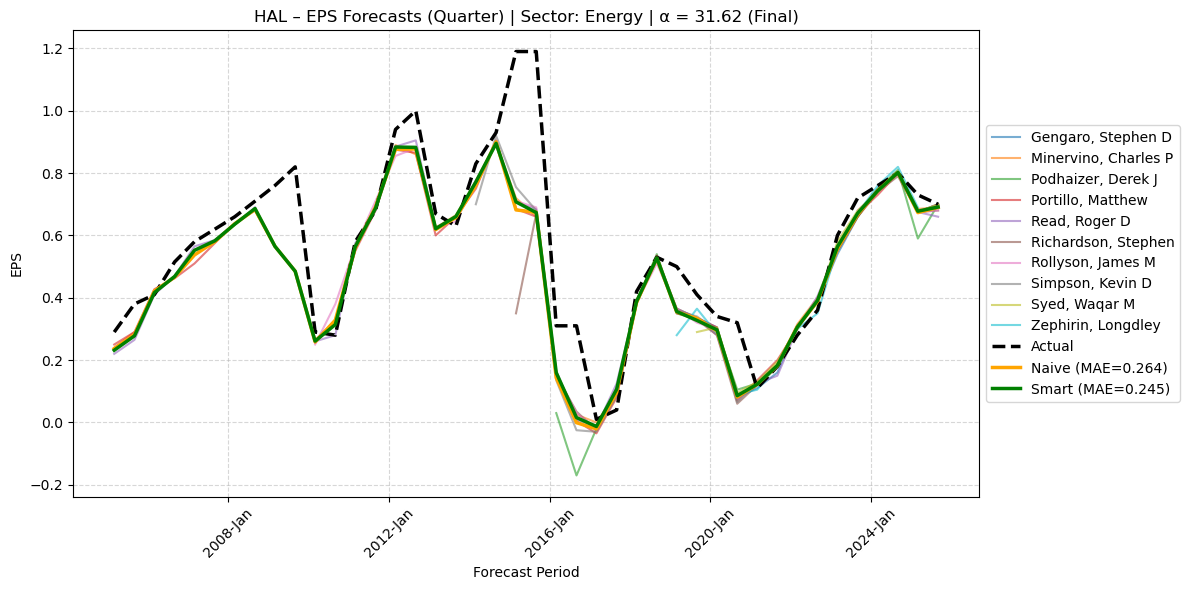

In [60]:
plot_forecasts_with_consensus_full(df, ticker="HAL", metric="EPS", horizon="Quarter", include_only_top=False)

Consensus periods (FULL DATA): 31


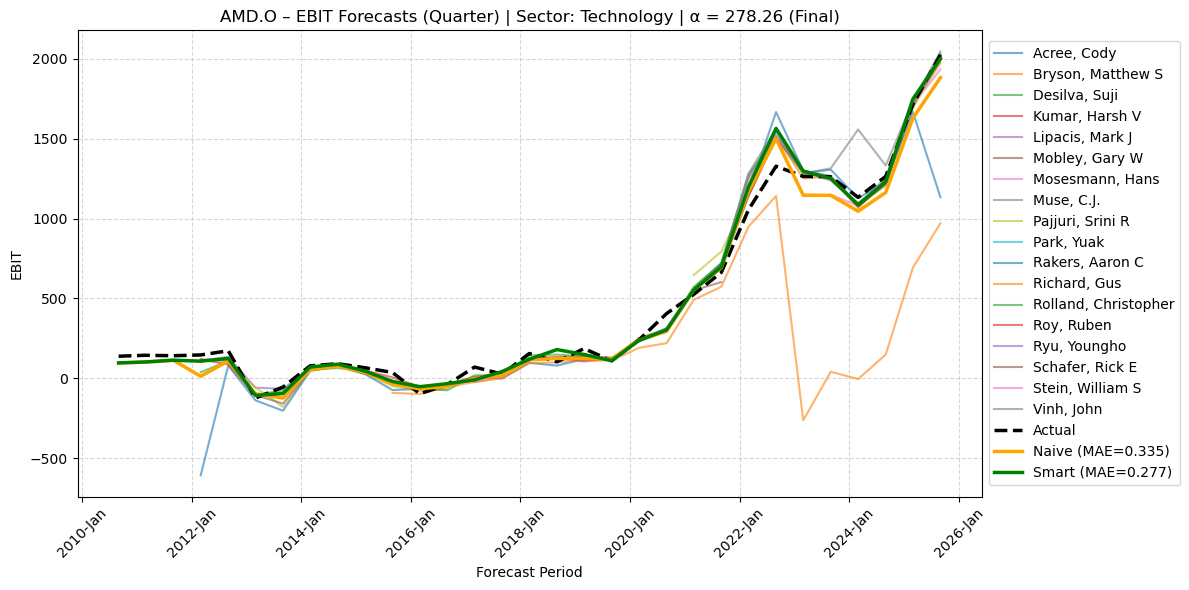

In [61]:
plot_forecasts_with_consensus_full(df, ticker="AMD.O", metric="EBIT", horizon="Quarter", include_only_top=False)

Consensus periods (FULL DATA): 37


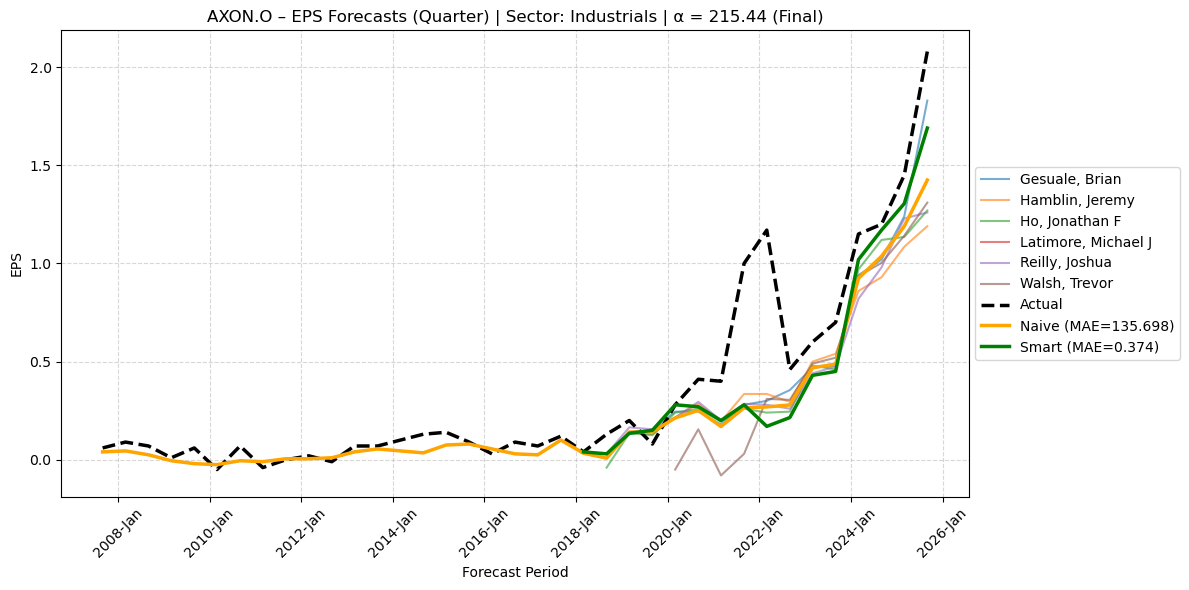

In [62]:
plot_forecasts_with_consensus_full(df, ticker="AXON.O", metric="EPS", horizon="Quarter", include_only_top=False)

## Approach 2: Systematic Bias Approach

(Aquest el faré jo també)

## Approach 3: Machine Learning (Supervised &/or Unsupervised)

Coses a tenir en compte per enric:

- CUIDADO AQUÍ PQ. AMB EL OHE DE TOTES LES CATEGÒRIQUES HI HA UN BLOW-UP DE LA PARRA DE LA RAM. ALGO HEM DE FER PER GESTIONAR AIXÒ SI VOLEM FER UN MODEL AMB ML.
- Es poden treure categòriques inútils potser.
- Les que serien imprescindibles mantenir serien la de Ticker, Analysts òbviament (pero hi ha 700 analysts i +200 companies, aixi q potser es podria pillar una sample), i estimate type potser tamb seria imp.
- Les altres de Contributor, Country, Industry etc. potser no tant (Sector probablement si ja q només son 10 categories)
- Eliminar variables redundats per evitar leakage (e.g: Predicted Value i Actual value) q donarien un leakage obvi si fem predicció de l'error absolut en %.
- Ticker i Company_Name obv. son redundants, o sigui eliminar alguna d les dos per fer OHE.
- Per les variables macro (numèriques totes) es pot fer un PCA o un kPCA (kPCA és mes fancy); i important fer el fit obviament al training set per evitar leakage de nou.

In [63]:
df.head()

,Ticker,Period,Horizon,Estimate_Type,Contributor,Analyst,Predicted_Value,Actual_Value,Currency,Country,...,Tech ETF,Financials ETF,Healthcare ETF,Energy ETF,Consumer Discretionary ETF,Utilities ETF,Consumer Staples ETF,Industrials ETF,Materials ETF,PctErr
0,ORCL.K,Q1 Aug-04,Quarter,Revenue,CITIZENS,"Walravens, Patrick D",2219.50,2215.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.002032
1,ORCL.K,Q1 Aug-04,Quarter,EPS,WILLIAM BLAIR & COMPANY,"Naji, Sebastien",0.10,0.1,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.000000
2,ORCL.K,Q1 Aug-04,Quarter,EPS,CITIZENS,"Walravens, Patrick D",0.09,0.1,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.099999
3,ORCL.K,Q1 Aug-04,Quarter,Net Income,CITIZENS,"Walravens, Patrick D",458.70,509.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.098821
4,ORCL.K,Q1 Aug-04,Quarter,Net Income,PIPER SANDLER COMPANIES,"Bracelin, Brent A",491.90,509.0,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.033595
